## 1. Carga de Librerías y Datos

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Se define la ruta del archivo de entrada
path_interim = '../data/interim/alzheimer_db.csv'

# Se cargan los datos
try:
    # Se añade el parámetro encoding='latin1' para leer caracteres en español.
    df_raw = pd.read_csv(path_interim, encoding='latin1')
    
    print("Datos cargados exitosamente.\n")
    print(f"Número de registros iniciales: {len(df_raw)}\n")
    print(df_raw.head())
except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo en la ruta: {path_interim}")
except Exception as e:
    print(f"Ocurrió un error al cargar los datos: {e}")

Datos cargados exitosamente.

Número de registros iniciales: 54912

    Año Semana          Entidad Ax_003 Valor
0  2014  sem02   Aguascalientes   Sem.     0
1  2014  sem02   Aguascalientes      H     0
2  2014  sem02   Aguascalientes      M     0
3  2014  sem02  Baja California   Sem.     0
4  2014  sem02  Baja California      H     0


## 2. Limpieza Inicial y Conversión de Tipos

In [13]:
# Se limpia la columna 'Semana' (ej. "sem01" -> 1)
df_raw['Semana'] = df_raw['Semana'].str.replace('sem', '', regex=False).astype(int)

# Se limpia la columna 'Valor' (reemplazando guiones por '0')
df_raw['Valor'] = df_raw['Valor'].replace('-', '0')

# Se convierte 'Valor' a numérico, manejando posibles errores
df_raw['Valor'] = pd.to_numeric(df_raw['Valor'], errors='coerce')

# Se rellenan con 0 los valores que no se pudieron convertir (si los hubiera)
df_raw['Valor'] = df_raw['Valor'].fillna(0).astype(int)

print("\nTipos de datos después de la limpieza:\n")
print(df_raw.info())


Tipos de datos después de la limpieza:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54912 entries, 0 to 54911
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Año      54912 non-null  int64 
 1   Semana   54912 non-null  int64 
 2   Entidad  54912 non-null  object
 3   Ax_003   54912 non-null  object
 4   Valor    54912 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ MB
None


## 3. Transformación de la Estructura (Pivotar)

In [14]:
print("\nPivotando la tabla...")

try:
    df_pivot = df_raw.pivot_table(
        index=['Año', 'Semana', 'Entidad'], # Las filas que queremos mantener
        columns='Ax_003',                  # La columna cuyas filas se volverán columnas
        values='Valor',                    # Los valores que irán en las nuevas columnas
        aggfunc='first'                    # Cómo manejar duplicados (tomar el primero)
    ).reset_index()

    # Se renombran las nuevas columnas para mayor claridad
    df_pivot = df_pivot.rename(columns={
        'Sem.': 'Nuevos_Casos_Semana',
        'H': 'Acum_Hombres',
        'M': 'Acum_Mujeres'
    })

    # Se limpia el nombre del índice de columnas
    df_pivot.columns.name = None

    print("Tabla pivotada exitosamente.")
    print(df_pivot.head())

except KeyError:
    print("Error: No se pudo pivotar. Asegúrarse de que las columnas 'Año', 'Semana', 'Entidad', 'Ax_003' y 'Valor' existan.")
except Exception as e:
    print(f"Ocurrió un error inesperado al pivotar: {e}")


Pivotando la tabla...
Tabla pivotada exitosamente.
    Año  Semana              Entidad  Acum_Hombres  Acum_Mujeres  \
0  2014       2       Aguascalientes             0             0   
1  2014       2      Baja California             0             0   
2  2014       2  Baja California Sur             0             0   
3  2014       2             Campeche             0             0   
4  2014       2              Chiapas             0             0   

   Nuevos_Casos_Semana  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  


## 4. Corrección de la Inconsistencia de Reinicio de Año (Semana 1) o baja de acumulados

Este paso se realiza porque, al analizar el dataset original, se observa que las semanas 1 normalmente abarcan días todavía del año anterior, y sus valores de conteo siguen representando el acumulado de dicho año pasado, no del reinicio. Asimismo, hay casos aislados donde se presenta una supuesta baja en los acumulados, lo cual no es posible.

La lógica para la corrección es la siguiente:

1. Ordenar los datos cronológicamente por cada estado.

2. Calcular la diferencia semanal (.diff()) de los acumulados para obtener los "nuevos casos".

3. Corregir los dos problemas que esto crea:

- Los NaN en la primera semana de toda la serie.

- Los valores negativos (por ejemplo -147) al inicio de cada año.

4. Nuestra regla de corrección será: si el valor es negativo o NaN, significa que es un reinicio, y el valor real de esa semana es simplemente el valor acumulado de esa misma semana.

In [15]:
print("\nIniciando corrección de la inconsistencia de reinicio de año...")

# 1. Se ordenan los datos para que .diff() funcione
df_pivot.sort_values(by=['Entidad', 'Año', 'Semana'], inplace=True)

# 2. Se calcula la diferencia semanal (nuevos casos) POR ESTADO
df_pivot['Nuevos_Hombres'] = df_pivot.groupby('Entidad')['Acum_Hombres'].diff()
df_pivot['Nuevos_Mujeres'] = df_pivot.groupby('Entidad')['Acum_Mujeres'].diff()

# 3. Se aplica la regla de corrección (para NaNs y Negativos)
# Si el valor es < 0 O es NaN, se usa el valor acumulado de esa semana.
# Si no, se usa el valor calculado por .diff().

# Corrección para Hombres
df_pivot['Nuevos_Hombres'] = np.where(
    (df_pivot['Nuevos_Hombres'] < 0) | (df_pivot['Nuevos_Hombres'].isnull()), # Condición
    df_pivot['Acum_Hombres'],  # Valor si la condición es Verdadera
    df_pivot['Nuevos_Hombres'] # Valor si la condición es Falsa
)

# Corrección para Mujeres
df_pivot['Nuevos_Mujeres'] = np.where(
    (df_pivot['Nuevos_Mujeres'] < 0) | (df_pivot['Nuevos_Mujeres'].isnull()), # Condición
    df_pivot['Acum_Mujeres'],  # Valor si la condición es Verdadera
    df_pivot['Nuevos_Mujeres'] # Valor si la condición es Falsa
)

# 4. Verificación
# Se buscan valores negativos que hayan quedado (no debería haber ninguno)
negativos_h = df_pivot[df_pivot['Nuevos_Hombres'] < 0].shape[0]
negativos_m = df_pivot[df_pivot['Nuevos_Mujeres'] < 0].shape[0]

if negativos_h == 0 and negativos_m == 0:
    print("Corrección de reinicios de año completada exitosamente. No hay valores negativos.")
else:
    print("ADVERTENCIA: Aún se detectaron valores negativos después de la corrección.")

df_pivot.head(165)


Iniciando corrección de la inconsistencia de reinicio de año...
Corrección de reinicios de año completada exitosamente. No hay valores negativos.


,Año,Semana,Entidad,Acum_Hombres,Acum_Mujeres,Nuevos_Casos_Semana,Nuevos_Hombres,Nuevos_Mujeres
0,2014,2,Aguascalientes,0,0,0,0.0,0.0
32,2014,3,Aguascalientes,0,0,0,0.0,0.0
64,2014,4,Aguascalientes,0,0,0,0.0,0.0
96,2014,5,Aguascalientes,0,0,0,0.0,0.0
128,2014,6,Aguascalientes,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...
5120,2017,5,Aguascalientes,0,1,0,0.0,0.0
5152,2017,6,Aguascalientes,0,1,0,0.0,0.0
5184,2017,7,Aguascalientes,0,1,0,0.0,0.0
5216,2017,8,Aguascalientes,0,3,2,0.0,2.0


## 5. Verificación de Consistencia (Diagnóstico)

En este paso, se valida la consistencia lógica de los datos. Se compara el total semanal reportado "Nuevos_Casos_Semana" (Verdad A) con la suma de los nuevos casos por género que calculamos en el paso anterior "Nuevos_Hombres" + "Nuevos_Mujeres" (Verdad B). Esto nos permitirá cuantificar el número de registros que presentan discrepancias.

In [16]:
print("\nIniciando Verificación de Consistencia de Datos...")

# Se parte del DataFrame df_pivot del Paso 4

# 1. Se crea la columna 'Total_Calculado' (Verdad B)
df_pivot['Total_Calculado'] = df_pivot['Nuevos_Hombres'] + df_pivot['Nuevos_Mujeres']

# 2. Se calcula la diferencia entre el total reportado (Verdad A) y el calculado (Verdad B)
df_pivot['Diferencia'] = df_pivot['Nuevos_Casos_Semana'] - df_pivot['Total_Calculado']

# 3. Se aíslan los registros que tienen una discrepancia (Diferencia != 0)
df_inconsistente = df_pivot[df_pivot['Diferencia'] != 0]

# 4. Se reportan los hallazgos
num_inconsistencias = len(df_inconsistente)
porcentaje = (num_inconsistencias / len(df_pivot)) * 100

if num_inconsistencias > 0:
    print(f"Se encontraron {num_inconsistencias} registros inconsistentes ({porcentaje:.2f}% del total).")
    print("Esto significa que 'Nuevos_Casos_Semana' no coincide con la suma de 'Nuevos_Hombres' y 'Nuevos_Mujeres'.")
    
    # Se muestra un resumen estadístico de qué tan grande es la diferencia
    print("\nEstadísticas de la discrepancia (Reportado - Calculado):")
    print(df_inconsistente['Diferencia'].describe())
    
    # Se muestran algunos ejemplos de estas inconsistencias
    print("\nEjemplos de registros inconsistentes:")
    print(df_inconsistente[['Año', 'Semana', 'Entidad', 'Nuevos_Casos_Semana', 'Nuevos_Hombres', 'Nuevos_Mujeres', 'Total_Calculado', 'Diferencia']].head())
else:
    print("No se encontraron inconsistencias entre los totales reportados y los calculados.")


Iniciando Verificación de Consistencia de Datos...
Se encontraron 696 registros inconsistentes (3.80% del total).
Esto significa que 'Nuevos_Casos_Semana' no coincide con la suma de 'Nuevos_Hombres' y 'Nuevos_Mujeres'.

Estadísticas de la discrepancia (Reportado - Calculado):
count    696.000000
mean      -9.673851
std       22.535502
min     -249.000000
25%       -8.000000
50%       -2.000000
75%       -1.000000
max        3.000000
Name: Diferencia, dtype: float64

Ejemplos de registros inconsistentes:
       Año  Semana         Entidad  Nuevos_Casos_Semana  Nuevos_Hombres  \
1344  2014      44  Aguascalientes                    0             1.0   
2624  2015      31  Aguascalientes                    0             1.0   
3040  2015      44  Aguascalientes                    0             0.0   
3584  2016       9  Aguascalientes                    0             0.0   
3808  2016      16  Aguascalientes                    0             0.0   

      Nuevos_Mujeres  Total_Calculado  

## 6. Aplicación de Fuente Única de Verdad (Tratamiento)

Basado en los hallazgos del Paso 5, existe información contradictoria en el DataFrame, por lo que se debe establecer una única fuente de verdad. Se ha decidido confiar en los datos de género (Nuevos_Hombres y Nuevos_Mujeres), ya que son más granulares y han sido sometidos a una limpieza lógica (Paso 4).

Por lo tanto, se descartará la columna original Nuevos_Casos_Semana y se reemplazará con nuestro Total_Calculado.

In [17]:
print("\nAplicando Fuente Única de Verdad...\n")

# 1. Se elimina la columna original inconsistente y la auxiliar de diferencia
df_pivot = df_pivot.drop(columns=['Nuevos_Casos_Semana', 'Diferencia'])

# 2. Se renombra la columna 'Total_Calculado' para que sea el nuevo total oficial
df_pivot = df_pivot.rename(columns={
    'Total_Calculado': 'Nuevos_Casos_Total'
})

print("Tratamiento completado. La columna 'Nuevos_Casos_Semana' ha sido reemplazada por 'Nuevos_Casos_Total' (calculado).\n")
print("El DataFrame ahora es internamente consistente.")
print(df_pivot.head())


Aplicando Fuente Única de Verdad...

Tratamiento completado. La columna 'Nuevos_Casos_Semana' ha sido reemplazada por 'Nuevos_Casos_Total' (calculado).

El DataFrame ahora es internamente consistente.
      Año  Semana         Entidad  Acum_Hombres  Acum_Mujeres  Nuevos_Hombres  \
0    2014       2  Aguascalientes             0             0             0.0   
32   2014       3  Aguascalientes             0             0             0.0   
64   2014       4  Aguascalientes             0             0             0.0   
96   2014       5  Aguascalientes             0             0             0.0   
128  2014       6  Aguascalientes             0             0             0.0   

     Nuevos_Mujeres  Nuevos_Casos_Total  
0               0.0                 0.0  
32              0.0                 0.0  
64              0.0                 0.0  
96              0.0                 0.0  
128             0.0                 0.0  


## 7. Creación de la Columna de Fecha

Se crea una columna Fecha formal a partir de las columnas Año y Semana. Esta columna es indispensable para cualquier análisis de series de tiempo, ya que permite a las herramientas de visualización y modelado entender la secuencia cronológica y el intervalo entre los puntos de datos.

In [18]:
print("\nCreando la Columna de Fecha...")

# 1. Se crea una columna de semana formateada (ej. 1 -> "01")
df_pivot['Semana_Str'] = df_pivot['Semana'].astype(str).str.zfill(2)

# 2. Se crea la columna de Fecha
# Se ancla al Domingo ('0') de esa semana.
try:
    df_pivot['Fecha'] = pd.to_datetime(
        df_pivot['Año'].astype(str) + df_pivot['Semana_Str'] + '0', # Se usa '0' para Domingo
        format='%Y%U%w' # Se usa %U para semana que inicia en Domingo
    )
except ValueError as e:
    print(f"Advertencia: Se encontró un problema al crear la fecha, usando 'coerce' para forzar. Error: {e}")
    df_pivot['Fecha'] = pd.to_datetime(
        df_pivot['Año'].astype(str) + df_pivot['Semana_Str'] + '0',
        format='%Y%U%w',
        errors='coerce'
    )

# 3. Se eliminan las filas donde la fecha no se pudo crear (si las hubiera)
original_len = len(df_pivot)
df_pivot.dropna(subset=['Fecha'], inplace=True)
if len(df_pivot) < original_len:
    print(f"Se eliminaron {original_len - len(df_pivot)} filas con fechas inválidas.")

print("Columna de Fecha (anclada en Domingo) creada exitosamente.")
df_pivot[['Fecha', 'Año', 'Semana', 'Entidad']].head()


Creando la Columna de Fecha...
Columna de Fecha (anclada en Domingo) creada exitosamente.


,Fecha,Año,Semana,Entidad
0,2014-01-12,2014,2,Aguascalientes
32,2014-01-19,2014,3,Aguascalientes
64,2014-01-26,2014,4,Aguascalientes
96,2014-02-02,2014,5,Aguascalientes
128,2014-02-09,2014,6,Aguascalientes


## 8. Consolidación de Semanas Duplicadas

Se ha detectado que el método de creación de fechas (Paso 7) genera fechas idénticas para semanas de fin/inicio de año (ej. Semana 53 de 2014 y Semana 1 de 2015). Esto crea registros duplicados (Fecha, Entidad) que corrompen la serie de tiempo. La solución es consolidar estos duplicados sumando sus valores de casos.

In [19]:
print("\nConsolidando Semanas de Fin/Inicio de Año...\n")

# 1. Diagnóstico: Se buscan y se cuentan los duplicados
duplicados_mask = df_pivot.duplicated(subset=['Fecha', 'Entidad'], keep=False)
duplicados_count = duplicados_mask.sum()

if duplicados_count > 0:
    print(f"Se encontraron {duplicados_count} registros involucrados en duplicaciones de fecha (ej. Sem 53/Sem 1).\n")
    print("Ejemplos de duplicados:")
    # Se muestran algunos ejemplos para validar
    print(df_pivot[duplicados_mask].sort_values(by=['Entidad', 'Fecha']).head())

    # 2. Corrección: Se agrupa por Entidad y Fecha para consolidar
    # Se suman las métricas de casos
    # Se toma el 'primer' valor para las etiquetas (Año, Semana, etc.)
    agregaciones = {
        'Nuevos_Casos_Total': 'sum',
        'Nuevos_Hombres': 'sum',
        'Nuevos_Mujeres': 'sum',
        'Acum_Hombres': 'last', # Tomar el último acumulado (el más actualizado)
        'Acum_Mujeres': 'last', # Tomar el último acumulado
        'Año': 'first',         # Etiqueta descriptiva
        'Semana': 'first'       # Etiqueta descriptiva
    }

    df_pivot = df_pivot.groupby(['Entidad', 'Fecha']).agg(agregaciones).reset_index()
    
    # Se re-ordenan las columnas como estaban
    df_pivot = df_pivot[['Fecha', 'Año', 'Semana', 'Entidad', 
                         'Nuevos_Casos_Total', 'Nuevos_Hombres', 'Nuevos_Mujeres',
                         'Acum_Hombres', 'Acum_Mujeres']]

    print("\nRegistros duplicados consolidados exitosamente.")

else:
    print("No se encontraron registros de fecha duplicados. No se requiere consolidación.")

print("Consolidación de semanas completada.")


Consolidando Semanas de Fin/Inicio de Año...

Se encontraron 128 registros involucrados en duplicaciones de fecha (ej. Sem 53/Sem 1).

Ejemplos de duplicados:
        Año  Semana          Entidad  Acum_Hombres  Acum_Mujeres  \
1632   2014      53   Aguascalientes             3             7   
1664   2015       1   Aguascalientes             3             9   
11648  2020      53   Aguascalientes             6             8   
11680  2021       1   Aguascalientes             6             8   
1633   2014      53  Baja California            22            56   

       Nuevos_Hombres  Nuevos_Mujeres  Nuevos_Casos_Total Semana_Str  \
1632              0.0             1.0                 1.0         53   
1664              0.0             2.0                 2.0         01   
11648             0.0             0.0                 0.0         53   
11680             0.0             0.0                 0.0         01   
1633              0.0             0.0                 0.0         53   

## 9. Validación Visual

Se grafica un ejemplo conteos de casos en determinado periodo, para una entidad federativa, con el fin de hacer una inspección general de las correcciones hechas.


Validación Visual de las Correcciones...


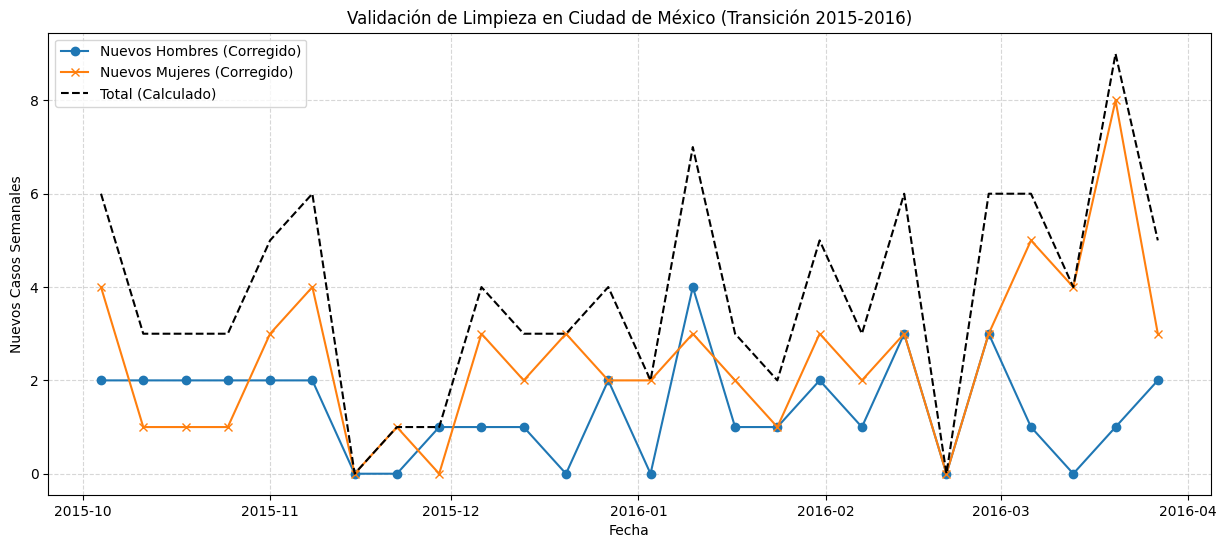

--- Fin de la Validación ---
Si la limpieza fue exitosa, las líneas de 'Nuevos Hombres' y 'Nuevos Mujeres' no deben caer por debajo de cero.
Además, la línea punteada 'Total (Calculado)' debe ser la suma exacta de las otras dos líneas.


In [20]:
print("\nValidación Visual de las Correcciones...")

# Se elige un estado para la "foto"
estado_a_validar = 'Ciudad de México'

# Se filtra el DataFrame por ese estado
df_validacion = df_pivot[df_pivot['Entidad'] == estado_a_validar].copy()

# Se selecciona un rango de fechas que incluya una transición de año
# (ej. últimas semanas de 2015 y primeras de 2016)
df_foto = df_validacion[
    (df_validacion['Fecha'] >= '2015-10-01') & 
    (df_validacion['Fecha'] <= '2016-03-31')
]

# Se grafica
plt.figure(figsize=(15, 6))
plt.plot(df_foto['Fecha'], df_foto['Nuevos_Hombres'], label='Nuevos Hombres (Corregido)', marker='o')
plt.plot(df_foto['Fecha'], df_foto['Nuevos_Mujeres'], label='Nuevos Mujeres (Corregido)', marker='x')
plt.plot(df_foto['Fecha'], df_foto['Nuevos_Casos_Total'], label='Total (Calculado)', linestyle='--', color='black')

plt.title(f"Validación de Limpieza en {estado_a_validar} (Transición 2015-2016)")
plt.ylabel("Nuevos Casos Semanales")
plt.xlabel("Fecha")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

print("--- Fin de la Validación ---")
print("Si la limpieza fue exitosa, las líneas de 'Nuevos Hombres' y 'Nuevos Mujeres' no deben caer por debajo de cero.")
print("Además, la línea punteada 'Total (Calculado)' debe ser la suma exacta de las otras dos líneas.")

## 10. Selección de columnas

Habiendo validado las correcciones, se decide descartar las columnas de Acumulados (Acum_Hombres, Acum_Mujeres), que ya cumplieron su propósito y ahora son redundantes.

In [21]:
print("\nSelección Final de Columnas...")

# 1. Se seleccionan y reordenan las columnas finales
df_clean = df_pivot[[
    'Fecha',
    'Año',
    'Semana',
    'Entidad',
    'Nuevos_Casos_Total',
    'Nuevos_Hombres',
    'Nuevos_Mujeres'
]].copy()

df_clean.head(15)


Selección Final de Columnas...


,Fecha,Año,Semana,Entidad,Nuevos_Casos_Total,Nuevos_Hombres,Nuevos_Mujeres
0,2014-01-12,2014,2,Aguascalientes,0.0,0.0,0.0
1,2014-01-19,2014,3,Aguascalientes,0.0,0.0,0.0
2,2014-01-26,2014,4,Aguascalientes,0.0,0.0,0.0
3,2014-02-02,2014,5,Aguascalientes,0.0,0.0,0.0
4,2014-02-09,2014,6,Aguascalientes,0.0,0.0,0.0
5,2014-02-16,2014,7,Aguascalientes,0.0,0.0,0.0
6,2014-02-23,2014,8,Aguascalientes,0.0,0.0,0.0
7,2014-03-02,2014,9,Aguascalientes,0.0,0.0,0.0
8,2014-03-09,2014,10,Aguascalientes,0.0,0.0,0.0
9,2014-03-16,2014,11,Aguascalientes,0.0,0.0,0.0


## 11. Tratamiento de Outliers (Valores Atípicos)

Habiendo asegurado la consistencia lógica de los datos, se porcede a validar y tratar la consistencia estadística. Los outliers (valores extremadamente altos e improbables, pero no lógicamente imposibles) pueden sesgar el análisis y el entrenamiento de los modelos.

Se implementará un método de umbral dinámico (Bandas de Normalidad) basado en una media y desviación estándar móviles (de 52 semanas, para capturar el ciclo anual). Este umbral se adaptará a la tendencia de los datos, permitiendo una detección de outliers contextualizada en el tiempo.


Tratamiento de Outliers (Versión con Umbral Dinámico y Redondeo)...
Calculando bandas dinámicas para 'Nuevos_Hombres'...
Número de outliers a tratar en 'Nuevos_Hombres': 329
Calculando bandas dinámicas para 'Nuevos_Mujeres'...
Número de outliers a tratar en 'Nuevos_Mujeres': 308

Capping dinámico de Hombres y Mujeres completado.
Redondeando componentes a números enteros...
Columna 'Nuevos_Casos_Total' re-calculada (consistente con enteros).

Generando visualización del efecto del tratamiento (Zoom 2015-2017)...


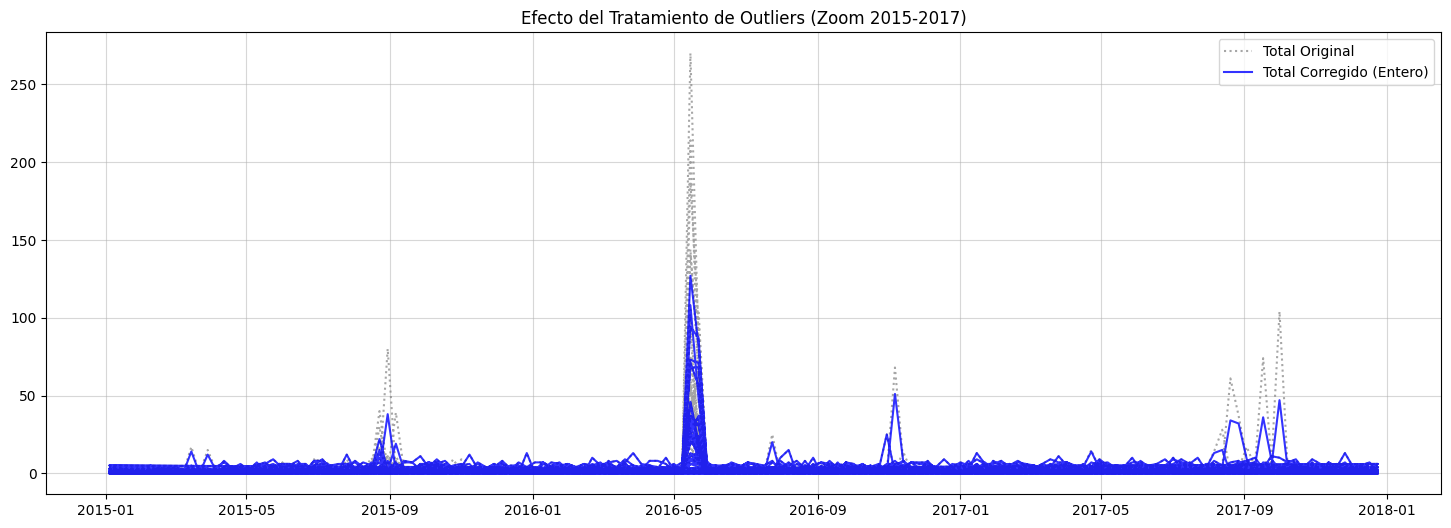


Estadísticas DESCRIPTIVAS (Después del Capping y Redondeo):
       Nuevos_Casos_Total  Nuevos_Hombres  Nuevos_Mujeres
count        18240.000000    18240.000000    18240.000000
mean             1.679605        0.672204        1.007401
std              3.431259        1.648960        2.158808
min              0.000000        0.000000        0.000000
25%              0.000000        0.000000        0.000000
50%              1.000000        0.000000        0.000000
75%              2.000000        1.000000        1.000000
max            127.000000       69.000000       70.000000


In [22]:
print("\nTratamiento de Outliers (Versión con Umbral Dinámico y Redondeo)...")

# Se parte del DataFrame 'df_clean' del Paso 10

# --- 1. Definición de Parámetros de la Ventana ---
ventana = 52
n_std = 3
columnas_raiz = ['Nuevos_Hombres', 'Nuevos_Mujeres']
df_corregido = df_clean.copy()

# --- 2. Cálculo de Bandas Dinámicas por Estado ---
for col in columnas_raiz:
    media_movil_col = f"Media_Movil_{col}"
    std_movil_col = f"Std_Movil_{col}"
    limite_sup_col = f"Limite_Sup_{col}"
    outlier_flag_col = f"Outlier_{col}"
    
    print(f"Calculando bandas dinámicas para '{col}'...")
    df_corregido[media_movil_col] = df_corregido.groupby('Entidad')[col].rolling(window=ventana, min_periods=1, center=True).mean().reset_index(level=0, drop=True)
    df_corregido[std_movil_col] = df_corregido.groupby('Entidad')[col].rolling(window=ventana, min_periods=1, center=True).std().reset_index(level=0, drop=True)

    df_corregido[media_movil_col] = df_corregido.groupby('Entidad')[media_movil_col].ffill().bfill()
    df_corregido[std_movil_col] = df_corregido.groupby('Entidad')[std_movil_col].ffill().bfill()
    df_corregido[limite_sup_col] = df_corregido[media_movil_col] + (n_std * df_corregido[std_movil_col])
    
    # --- 3. Conteo de Registros ---
    df_corregido[outlier_flag_col] = df_corregido[col] > df_corregido[limite_sup_col]
    print(f"Número de outliers a tratar en '{col}': {df_corregido[outlier_flag_col].sum()}")

    # --- 4. Tratamiento (Capping) Dinámico ---
    # Se aplica el capping (esto introduce floats)
    df_corregido[col] = df_corregido.apply(lambda row: min(row[col], row[limite_sup_col]), axis=1)

print("\nCapping dinámico de Hombres y Mujeres completado.")

# --- 5. (NUEVO) Redondeo de Componentes a Enteros ---
print("Redondeando componentes a números enteros...")
for col in columnas_raiz:
    # Se redondea al entero más cercano y se convierte a tipo int
    df_corregido[col] = np.round(df_corregido[col]).astype(int)

# --- 6. Corrección Lógica (Re-cálculo del Total) ---
# Se recalcula el total usando los componentes YA REDONDEADOS
df_corregido['Nuevos_Casos_Total'] = df_corregido['Nuevos_Hombres'] + df_corregido['Nuevos_Mujeres']
print("Columna 'Nuevos_Casos_Total' re-calculada (consistente con enteros).")


# --- 7. Visualización del Efecto (Zoom de 3 Años) ---
print("\nGenerando visualización del efecto del tratamiento (Zoom 2015-2017)...")
df_corregido['Total_Original'] = df_clean['Nuevos_Casos_Total']
df_zoom = df_corregido[(df_corregido['Fecha'] >= '2015-01-01') & (df_corregido['Fecha'] < '2018-01-01')]

plt.figure(figsize=(18, 6))
plt.plot(df_zoom['Fecha'], df_zoom['Total_Original'], label='Total Original', color='gray', alpha=0.7, linestyle=':')
plt.plot(df_zoom['Fecha'], df_zoom['Nuevos_Casos_Total'], label='Total Corregido (Entero)', color='blue', alpha=0.8)
plt.title('Efecto del Tratamiento de Outliers (Zoom 2015-2017)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# --- 8. Limpieza Final ---
columnas_auxiliares = [col for col in df_corregido.columns if 'Media_Movil_' in col or 'Std_Movil_' in col or 'Limite_Sup_' in col or 'Outlier_' in col or 'Total_Original' in col]
df_clean = df_corregido.drop(columns=columnas_auxiliares)

print("\nEstadísticas DESCRIPTIVAS (Después del Capping y Redondeo):")
print(df_clean[['Nuevos_Casos_Total', 'Nuevos_Hombres', 'Nuevos_Mujeres']].describe())

## 12. Guardado de Versiones del DataFrame Procesado

Habiendo completado los pasos de limpieza, consistencia y tratamiento de outliers, el DataFrame (df_clean) está en su versión final. Se procede a guardarlo en tres formatos diferentes en la carpeta processed para ser consumidos por los distintos notebooks de modelado, según los requerimientos.

In [23]:
print("\nGuardando Versiones del Archivo Final...\n")

# Se parte del DataFrame 'df_clean' (resultado del Paso 11)

# --- 1. Definición de Rutas de Salida ---
path_v1_mf = '../data/processed/data_processed_v4_NoAcum_MF.csv'
path_v2_total_entity = '../data/processed/data_processed_v4_NoAcum_Total.csv'
path_v3_national = '../data/processed/data_processed_v4_National_NoAcum_Total.csv'

# --- 2. Creación y Guardado: Versión 1 (Hombres y Mujeres por Entidad) ---
print(f"Generando Versión 1 (MF por Entidad) en: {path_v1_mf}...")
df_v1 = df_clean[[
    'Año',
    'Semana',
    'Fecha',
    'Entidad',
    'Nuevos_Hombres',
    'Nuevos_Mujeres'
]].copy()

# Se renombran las columnas para tener consistencia con las versiones previas
df_v1 = df_v1.rename(columns={
    'Año': 'Year',
    'Semana': 'Week',
    'Fecha': 'Date',
    'Entidad': 'Entity',
    'Nuevos_Hombres': 'M',
    'Nuevos_Mujeres': 'F'
})
df_v1.to_csv(path_v1_mf, index=False)
print("...Versión 1 guardada.")


# --- 3. Creación y Guardado: Versión 2 (Total por Entidad) ---
print(f"\nGenerando Versión 2 (Total por Entidad) en: {path_v2_total_entity}...")
df_v2 = df_clean[[
    'Año',
    'Semana',
    'Fecha',
    'Entidad',
    'Nuevos_Casos_Total'
]].copy()

# Se renombran las columnas según la especificación
df_v2 = df_v2.rename(columns={
    'Año': 'Year',
    'Semana': 'Week',
    'Fecha': 'Date',
    'Entidad': 'Entity',
    'Nuevos_Casos_Total': 'Total_Cases'
})
df_v2.to_csv(path_v2_total_entity, index=False)
print("...Versión 2 guardada.")


# --- 4. Creación y Guardado: Versión 3 (Total Nacional) ---
print(f"\nGenerando Versión 3 (Total Nacional) en: {path_v3_national}...")

# Se agrupan todos los estados sumando el total
df_national = df_clean.groupby(['Fecha', 'Año', 'Semana'])['Nuevos_Casos_Total'].sum().reset_index()

# Se seleccionan y renombran las columnas
df_v3 = df_national[['Año', 'Semana', 'Fecha', 'Nuevos_Casos_Total']]
df_v3 = df_v3.rename(columns={
    'Año': 'Year',
    'Semana': 'Week',
    'Fecha': 'Date',
    'Nuevos_Casos_Total': 'Total_Cases'
})
df_v3.to_csv(path_v3_national, index=False)
print("...Versión 3 guardada.")


print("\nProceso de limpieza y guardado completado")
print(f"Se generaron 3 archivos CSV en la carpeta '../data/processed/'.")


Guardando Versiones del Archivo Final...

Generando Versión 1 (MF por Entidad) en: ../data/processed/data_processed_v4_NoAcum_MF.csv...
...Versión 1 guardada.

Generando Versión 2 (Total por Entidad) en: ../data/processed/data_processed_v4_NoAcum_Total.csv...
...Versión 2 guardada.

Generando Versión 3 (Total Nacional) en: ../data/processed/data_processed_v4_National_NoAcum_Total.csv...
...Versión 3 guardada.

Proceso de limpieza y guardado completado
Se generaron 3 archivos CSV en la carpeta '../data/processed/'.
